**Simple supported beam adaptive method with elasticity consideration**





Here in this case refered to Ehsan et al works in ***A deep learning framework for solution and discovery in solid mechanics***. We don't have to reconsider much temporal solutions for the beam state. All these have to be included to the lost function in training phase. They used Sciann for higher complexity for solving different problems and approached elasticity  as 2D solving displacement through x and y axis.

I worked background to update boundaries to accept two dimentional inputs (x,y) and target one or two considered axis.

The beam equation result on 
\begin{align} 
 EI\frac{\partial^4 w}{\partial x^4} +\mu\frac{\partial^2 w}{\partial t^2} =q(x)   
\end{align}

are turned to simply to

\begin{align} 
 EI\frac{\partial^4 w}{\partial x^4}=q(x)
\end{align}

as an ordinary differential equation

cloning from github essentials files

In [262]:
! git  clone --recursive  https://github.com/cmi-kamalos/PINN_Structural_health_monotoring

fatal: destination path 'PINN_Structural_health_monotoring' already exists and is not an empty directory.


switching to tensordiff folders (forked works from tensordiffeq)

In [263]:
cd /content/PINN_Structural_health_monotoring/from_tensordiff

/content/PINN_Structural_health_monotoring/from_tensordiff


In [264]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [265]:
 pip install pyDOE2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [266]:
pip install tqdm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [267]:
pip install pyfiglet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [268]:
import math
import os
import numpy as np
import sys
import inspect
import tensorflow as tf
import os


In [269]:
import utils
import domains
import models 
import plotting
import bnd
import helpers
import networks
import output
import sampling
import fit
import __init__


tensordiff *essentials* **package**

In [270]:
from  bnd import *
from  domains import DomainND
from utils import constant
from models import CollocationSolverND
from tensorflow import sin, cos


Domains

In [271]:
Domain =DomainND(["y", "x"])

Domain.add("y", [0.0, 1.0], 150)
Domain.add("x", [0.0, 1.0], 150)


Generate **Collocations** points

In [272]:
N_f = 22500
Domain.generate_collocation_points(N_f)

*exact* solution function

In [273]:

def f_real(x,y):
      return np.cos( 2*math.pi*x) * np.sin((math.pi * y))

function input corresponding to horizontal or vertical displacement

In [274]:
def dispy(x,y):
    Q=4.0
    c1=4.0
    pi=math.pi
    return (sin(pi*x) * Q * y**c1/c1)

def dispx(x,y):
    pi=math.pi
    return cos(2*pi*x) * sin(pi*y)


Bodyfunction of the body forces of the aforementioned functions

In [275]:
def bodyfx(x,y):
    lmbd = 1.0
    Q=4.0
    pi=math.pi
    mu=0.5
    frc = - lmbd*(4*pi**2*cos(2*pi*x)*sin(pi*y) - Q*y**3*pi*cos(pi*x)) \
          - mu*(pi**2*cos(2*pi*x)*sin(pi*y) - Q*y**3*pi*cos(pi*x)) \
          - 8*mu*pi**2*cos(2*pi*x)*sin(pi*y)
    return frc
def bodyfy(x, y):
    pi=math.pi
    lmbd = 1
    mu=0.5
    Q=4
    frc = lmbd*(3*Q*y**2*sin(pi*x) - 2*pi**2*cos(pi*y)*sin(2*pi*x)) \
          - mu*(2*pi**2*cos(pi*y)*np.sin(2*pi*x) + (Q*y**4*pi**2*sin(pi*x))/4) \
          + 6*Q*mu*y**2*sin(pi*x)
    return frc

In case our network predict stress and strain of the beam

In [276]:
def strainxx(x,y):
    pi=math.pi
   
    Q=constant(4.0)
    return -2*pi*np.sin(2*pi*x)*np.sin(pi*y)

def strainyy(x,y):
    pi=math.pi
    Q=4.0
    return np.sin(pi*x)*Q*y**3
def strainxy(x,y):
    pi=math.pi
    Q=4.0
    return 0.5*(pi*np.cos(2*pi*x)*np.cos(pi*y) + pi*np.cos(pi*x)*Q*y**4/4)

In [277]:
def stressxy(x,y):
    mu=constant(0.5)
    return 2.0*mu*strainxy(x,y)

def stressxx(x,y):
    lmbd = 1.0
    mu=0.5
    return (lmbd+0.5*mu)*strainxx(x,y) + lmbd*strainyy(x,y)

def stressyy(x,y):
    lmbd = 1.0
    mu=0.5
    return (lmbd+2*mu)*strainyy(x,y) + lmbd*strainxx(x,y)

def stressxy(x,y):
    mu=constant(0.5)
    return 2.0*mu*strainxy(x,y)


**Dirichlet and neumann boundary**

In [278]:
bnd_x_0=dirichletBC(Domain, val=0.0, var="y", target="lower")

bnd_x_1=dirichletBC(Domain, val=0.0, var="y", target="upper")


bnd_x_l=FunctionDirichletBC(Domain,fun=dispx, var=["y"], target="lower", func_inputs=['x','y'], n_values=150)
bnd_x_u=FunctionDirichletBC(Domain,fun=dispx, var=["y"], target="upper",func_inputs=['x','y'], n_values=150)

bnd_xx_u=FunctionDirichletBC(Domain,fun=stressxx, var=["y"], target="upper", func_inputs=['x','y'], n_values=50)
bnd_xx_l=FunctionDirichletBC(Domain,fun=stressxx, var=["y"], target="lower", func_inputs=['x','y'], n_values=50)

# bnd_xy_x_l=FunctionDirichletBC(Domain,fun=stressxy, var=["x"], target="lower", func_inputs=['x','y'], n_values=50)
# bnd_xy_x_u=FunctionDirichletBC(Domain,fun=stressxy, var=["x"], target="upper", func_inputs=['x','y'], n_values=50)

# bnd_xy_y_l=FunctionDirichletBC(Domain,fun=stressxy, var=["y"], target="lower", func_inputs=['x','y'], n_values=50)
# bnd_xy_y_u=FunctionDirichletBC(Domain,fun=stressxy, var=["y"], target="upper", func_inputs=['x','y'], n_values=50)

bnd_bd_x_l=FunctionDirichletBC(Domain,fun=bodyfx, var=["y"], target="lower", func_inputs=['x','y'], n_values=150)
bnd_bd_x_u=FunctionDirichletBC(Domain,fun=bodyfx, var=["y"], target="upper", func_inputs=['x','y'], n_values=150)


*Boundary conditions*

In [279]:
BCs = [bnd_x_0,bnd_x_1,bnd_x_l,bnd_xx_l,bnd_xx_u,bnd_x_u,bnd_bd_x_l,bnd_bd_x_u]

**Model**

In [280]:
def f_model(u_model,y, x):
    u = u_model(tf.concat([y, x], 1))
    u_x = tf.gradients(u, y)[0]
    u_xx = tf.gradients(u_x, y)[0]
    u_xxx=tf.gradients(u_x, y)[0]
    u_x4=tf.gradients(u_xxx,y)[0]
    a1 = constant(2.0)
    pi = constant(math.pi)

    # we use this specific forcing term because we have an exact analytical solution for this case
    # to compare the results of the PINN solution
    # note that we must use tensorflow math primitives such as sin, cos, etc!
    forcing = -cos( a1*math.pi*x) * sin((math.pi * y))
    f_u=u_x4-forcing
    return f_u

Structure of w (layers)

In [281]:
layer_sizes = [2,100,100,100,1]

*collocation solver*

In [282]:
model = CollocationSolverND()



In [283]:
model.compile(layer_sizes, f_model, Domain, BCs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Reproduce results from ***Raissi*** and the ***SA-PINNs*** paper, train for 10k newton and 10k adam

In [284]:
model.fit(tf_iter=10000, newton_iter=10000)

    ____  _           
   / __ \(_)___  ____ 
  / /_/ / / __ \/ __ \
 / ____/ / / / / / / /
/_/   /_/_/ /_/_/ /_/ 
                      

Neural Network Model Summary

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 100)               300       
                                                                 
 dense_33 (Dense)            (None, 100)               10100     
                                                                 
 dense_34 (Dense)            (None, 100)               10100     
                                                                 
 dense_35 (Dense)            (None, 1)                 101       
                                                                 
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________
None
Starting

  0%|          | 0/10000 [00:00<?, ?it/s]

Starting L-BFGS training
Executing eager-mode L-BFGS


  0%|          | 0/10000 [00:00<?, ?it/s]

In [285]:
model.save("'trained-model.h5")

In [286]:
nx, nt = (150, 150)

setup conditions

In [287]:
x_ = np.linspace(0, 1, nx)
t_ = np.linspace(0, 1, nt)

xv, yv = np.meshgrid(x_,t_)



x = np.reshape(x_, (-1, 1))
t = np.reshape(t_, (-1, 1))

Exacte solution

In [288]:
z=f_real(xv,yv)

Exact_u=z


Flatten for use

In [289]:
u_star = Exact_u.flatten()[:, None]

create a mesh

In [290]:
y = Domain.domaindict[0]['ylinspace']
x = Domain.domaindict[1]["xlinspace"]

X, T = np.meshgrid(y, x)

In [291]:
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

predict

In [292]:
u_pred, f_u_pred = model.predict(X_star)

Error margins

In [293]:
error_u = helpers.find_L2_error(u_pred, u_star)
print('Error u: %e' % (error_u))

Error u: 1.001328e+00


Plotting prediction, exact solution and residual

Exact_u (150, 150) domain (150,) (150, 150)


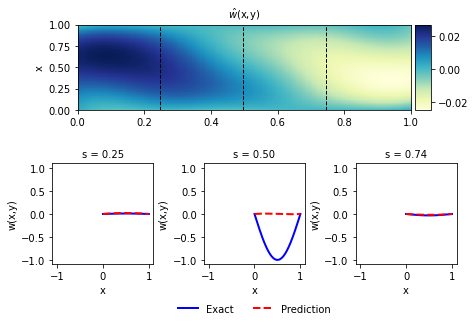

In [294]:
U_pred = plotting.get_griddata(X_star, u_pred.flatten(), (X, T))
FU_pred = plotting.get_griddata(X_star, f_u_pred.flatten(), (X, T))

lb = np.array([0.0, 0.0])
ub = np.array([1.0, 1.0])
plotting.plot_solution_Beam(model, [x, y], ub=ub, lb=lb, Exact_u=Exact_u)


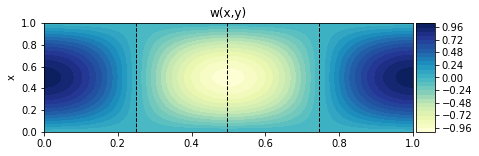

In [295]:
plotting.plot_beam(y,x,z,ub, lb)

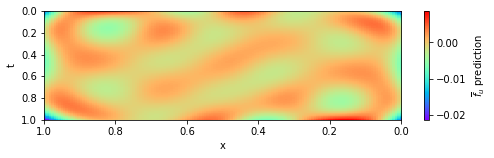

In [296]:
plotting.plot_residuals(FU_pred,lb,ub)